In [268]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_product, matrix_transpose, rotation_matrix
import pickle 
import scipy.interpolate as scint
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import gala.coordinates as gc

In [50]:
class ArbitraryPoleFrame(coord.BaseCoordinateFrame):
    
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }
    
    pole = coord.CoordinateAttribute(frame=coord.ICRS)    
    roll = coord.QuantityAttribute(default=0*u.degree)

In [51]:
@frame_transform_graph.transform(coord.DynamicMatrixTransform, coord.ICRS, ArbitraryPoleFrame)
def icrs_to_arbpole(icrs_coord, arbpole_frame):
    
    roll = arbpole_frame.roll
    pole = arbpole_frame.pole
    
    # Align z(new) with direction to M31
    mat1 = rotation_matrix(-pole.dec, 'y')
    mat2 = rotation_matrix(pole.ra, 'z')
    mat3 = rotation_matrix(roll, 'z')
    mat4 = rotation_matrix(90*u.degree, 'y')
    R = matrix_product(mat4, mat1, mat2, mat3)
    
    return R

@frame_transform_graph.transform(coord.DynamicMatrixTransform, ArbitraryPoleFrame, coord.ICRS)
def arbpole_to_icrs(arbpole_coord, icrs_frame):
    return matrix_transpose(icrs_to_arbpole(None, arbpole_coord))

In [ ]:
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]



In [52]:
with open('gaiasdssHaloNew_30b.pkl') as f:
    data = pickle.load(f)

In [53]:
xkey = 's_ra1'
ykey = 's_dec1'
pmxkey = 'pmra_new'
pmykey = 'pmdec_new' 

In [281]:
#set up search parameters
#propermotion not perpendicular to the great circle (pmphi2 ~ 0)
#propermotion along great circle < 20 mas/yr
pmphi1_center = 0.*u.mas/u.yr
pmphi2_center = 0.*u.mas/u.yr
pmphi1_width = 15.*u.mas/u.yr
pmphi2_width = 5.*u.mas/u.yr

#search various segmets of phi1
#constrain phi2 to be < 0.25 degrees from great circle
deltaphi1_search = 5.*u.deg #shift of phi1 when searching 
deltaphi2_bin = 0.1*u.deg        #width of bins when fitting for signal and background

phi1_width = deltaphi1_search*2. #width of phi1 for search
phi2_width = 0.25*u.deg          #width of phi2, close to equator
phi1_left_edges = np.arange(0., 360., deltaphi1_search.value)*u.deg
phi1_right_edges = phi1_left_edges + phi1_width
phi1_centers = (phi1_right_edges + phi1_left_edges)/2.
for x in [phi1_centers, phi1_right_edges]:
    x[x > 360.*u.deg] =  x[x > 360.*u.deg] - 360.*u.deg
phi2_center = 0.*u.deg           #equator

background_center = 0.*u.deg     #center of background filter
background_widthmax = 2.*u.deg   #maximum extent to calculate background
background_widthmin = phi2_width #minimum extent for background, exclude signal 

signalbins = np.arange(-phi2_width.value, phi2_width.value, deltaphi2_bin.value)*u.deg
signalcenters = (signalbins[1:]+signalbins[:-1])/2.

backgroundbins_low  = np.arange(-background_widthmax.value, -background_widthmin.value, deltaphi2_bin.value)*u.deg 
backgroundbins_high = np.arange(background_widthmin.value,  background_widthmax.value, deltaphi2_bin.value)*u.deg
backgroundcenters_low = (backgroundbins_low[1:]+backgroundbins_low[:-1])/2.
backgroundcenters_high = (backgroundbins_high[1:]+backgroundbins_high[:-1])/2.

allbins = np.arange(-background_widthmax.value, background_widthmax.value, deltaphi2_bin.value)*u.deg
allcenters = (allbins[1:] + allbins[:-1])/2.

In [164]:
#define coordinate system for data
sky = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg, pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr)


In [252]:
#define ra, dec of great circle pole
rapole  = 34.5987*u.deg
decpole = 29.7331*u.deg

pole = coord.ICRS(ra=rapole, 
                  dec=decpole)
frame = ArbitraryPoleFrame(pole=pole)

#align frame with pole 
newframe = sky.transform_to(frame) #frame
pmphi1 = newframe.pm_phi1_cosphi2
pmphi2 = newframe.pm_phi2
phi1 = newframe.phi1
phi2 = newframe.phi2


In [253]:
#select stars that have propermotion in Phi2 of +- 5 mas/yr and Phi1 of +- 20 mas/yr
#elliptical shape because who knows ! but square sounds bad
pmindices = (pmphi1/pmphi1_width)**2 + (pmphi2/pmphi2_width)**2. <= 1.
print np.sum(pmindices)

5909775


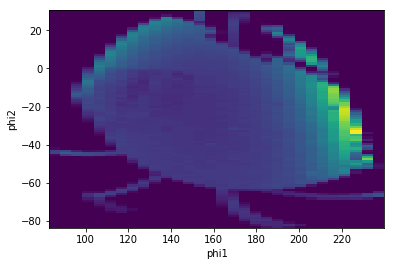

In [255]:
pmalpha_center = -6.0*u.mas/u.yr
pmdelta_center = -11.*u.mas/u.yr

extent_along_stream = 30*u.mas/u.yr
width_of_stream = 10*u.mas/u.yr
indices = (np.abs(pmphi1) < extent_along_stream) & (np.abs(pmphi2) < width_of_stream) 

x = phi1[indices].value
y = phi2[indices].value
#x[x > 180.] = x[x > 180.] - 360.
plt.hist2d(x, y, bins=[30,100]) #, range= [[-80, 210],[-10, 10]] )
plt.xlabel('phi1')
plt.ylabel('phi2')
plt.savefig('gd1rot.pdf')

Text(0.5,1,u'gd1')

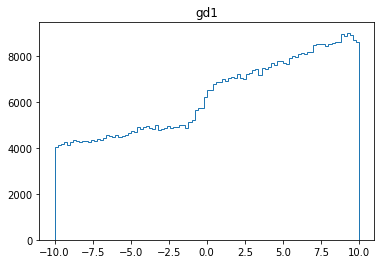

In [257]:
ind2=(x > 110) & (x < 140) & (np.abs(y) < 10)
plt.hist(y[ind2], bins=100, histtype='step')
plt.title('gd1')

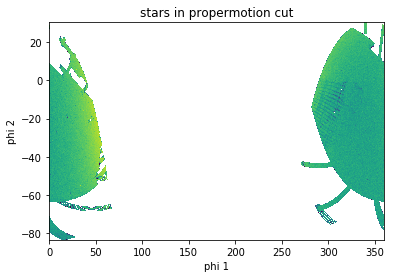

In [250]:
plt.hist2d(phi1, phi2, bins=1000, norm=mpl.colors.LogNorm())
#plt.ylim(-10, 10)
plt.xlabel('phi 1')
plt.ylabel('phi 2')
plt.title('stars in propermotion cut')
plt.savefig('rotatedFrame.pdf', rasterized=True)

Text(0.5,1,u'propermotions in pm cut')

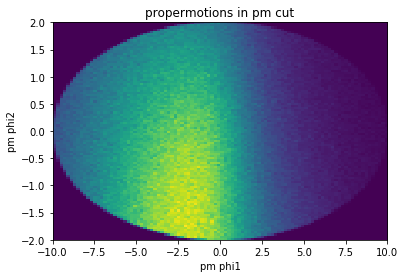

In [177]:
plt.hist2d(pmphi1[pmindices], pmphi2[pmindices], bins=100)
plt.xlabel('pm phi1')
plt.ylabel('pm phi2')
plt.title('propermotions in pm cut')

In [168]:
print phi1_edges
phi1bins = np.digitize(phi1, phi1_edges)

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.] deg


In [280]:
backgroundbins

<Quantity [-2.  ,-1.9 ,-1.8 ,-1.7 ,-1.6 ,-1.5 ,-1.4 ,-1.3 ,-1.2 ,-1.1 ,
           -1.  ,-0.9 ,-0.8 ,-0.7 ,-0.6 ,-0.5 ,-0.4 ,-0.3 , 0.25, 0.35,
            0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35,
            1.45, 1.55, 1.65, 1.75, 1.85, 1.95] (Unit not initialised)>

In [261]:
phi1_left_edges

<Quantity [   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,
             50.,  55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95.,
            100., 105., 110., 115., 120., 125., 130., 135., 140., 145.,
            150., 155., 160., 165., 170., 175., 180., 185., 190., 195.,
            200., 205., 210., 215., 220., 225., 230., 235., 240., 245.,
            250., 255., 260., 265., 270., 275., 280., 285., 290., 295.,
            300., 305., 310., 315., 320., 325., 330., 335., 340., 345.,
            350., 355.] deg>

In [264]:
np.where(np.array(phi1_left_edges) == 120)

(array([24]),)

3198
18899
4.12069384748


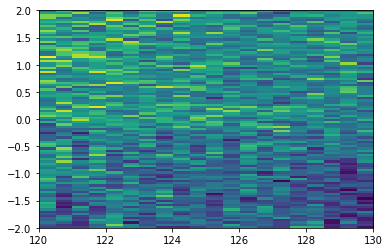

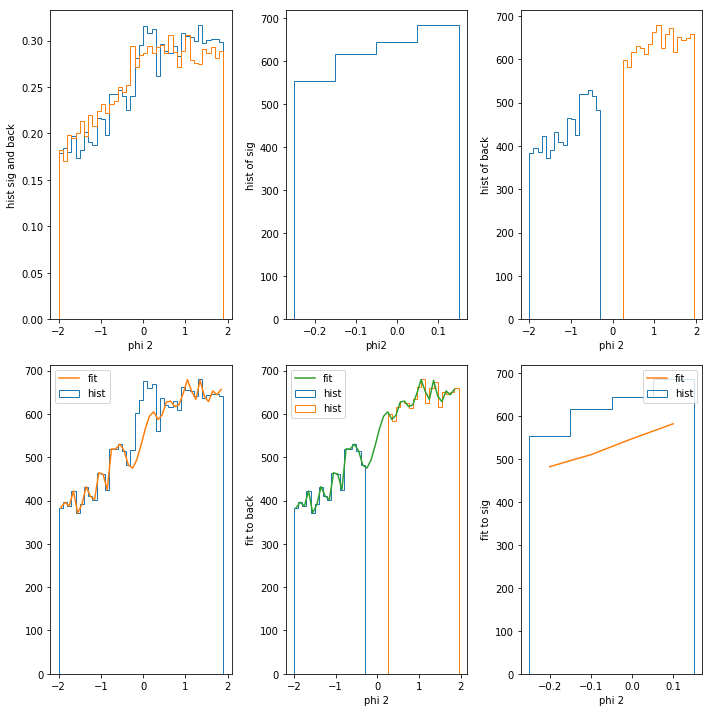

In [291]:
figAll, axesAll = plt.subplots()
fig, axes = plt.subplots(2, 3, figsize=(10,10))
axes = axes.flatten()
excess = np.zeros(len(phi1_right_edges))
#for i, (l, r) in enumerate(zip(phi1_left_edges[23:24], phi1_right_edges[11:12])): #np.unique(phi1bins):
for i, l, r in zip([24], [phi1_left_edges[24]], [phi1_right_edges[24]]):
    #search for over densities of stars along equator in Phi1 delta degree increments
    #stream is Phi2 = +-0.25 degrees from equator
    #background is Phi2 = +-2 degrees excluding stream 
    deltaPhi2 = phi2 - phi2_center
    
    posindices  = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= phi2_width) & pmindices
            
    notindices = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= background_widthmax) & ~pmindices
            
    backindices_low = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (deltaPhi2 > -background_widthmax) & \
                  (deltaPhi2 < -background_widthmin) & pmindices
    backindices_high = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (deltaPhi2 < background_widthmax) & \
                  (deltaPhi2 > background_widthmin) & pmindices
    allindices = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= background_widthmax) & pmindices
    axesAll.hist2d(phi1[allindices], phi2[allindices], bins=[20, 100])
    
    print np.sum(posindices)
    print np.sum(backindices)
    signal, bins_edges = np.histogram(phi2[posindices], bins=signalbins)
    background_low, bin_edges = np.histogram(phi2[backindices_low], bins=backgroundbins_low)
    background_high, bin_edges = np.histogram(phi2[backindices_high], bins=backgroundbins_high)
    #backgroundcenters = backgroundcenters[background > 0]
    #background = background[background > 0]
    axes[0].hist(phi2[allindices], bins=allbins, histtype='step', normed=True)
    axes[0].hist(phi2[notindices], bins=allbins, histtype='step', normed=True)
    axes[0].set_xlabel('phi 2')
    axes[0].set_ylabel('hist sig and back')
    axes[1].hist(phi2[posindices], bins=signalbins, histtype='step')
    axes[1].set_xlabel('phi2')
    axes[1].set_ylabel('hist of sig')
    axes[2].hist(phi2[backindices_low], bins=backgroundbins_low, histtype='step')
    axes[2].hist(phi2[backindices_high], bins=backgroundbins_high, histtype='step')
    axes[2].set_xlabel('phi 2')
    axes[2].set_ylabel('hist of back')
    bcfit = np.hstack((backgroundcenters_low, backgroundcenters_high))
    bsfit = np.hstack((background_low.astype('float64'), background_high.astype('float64')))
    cs = scint.CubicSpline(bcfit, bsfit)
    #cs = scint.UnivariateSpline(bcfit, bsfit, s=0.001)
    axes[3].hist(phi2[allindices], bins = allbins, label='hist', histtype='step')
    axes[3].plot(allcenters, cs(allcenters), label='fit')
    axes[3].legend()
    axes[4].hist(phi2[backindices_low], bins=backgroundbins_low, label='hist', histtype='step')
    axes[4].hist(phi2[backindices_high], bins=backgroundbins_high, label='hist', histtype='step')
    axes[4].plot(allcenters, cs(allcenters), label='fit')
    axes[4].set_xlabel('phi 2')
    axes[4].set_ylabel('fit to back')
    axes[4].legend()
    axes[5].hist(phi2[posindices], bins=signalbins, label='hist', histtype='step')
    axes[5].plot(signalcenters, cs(signalcenters), label='fit')
    #print signalcenters
    #print cs(signalcenters)
    axes[5].set_xlabel('phi 2')
    axes[5].set_ylabel('fit to sig')
    axes[5].legend()
    signal = signal.astype('float64') - cs(signalcenters)
    excess[i] = np.sum(signal)/len(signal)/np.sqrt(np.mean(cs(signalcenters)))
    print excess[i]
plt.tight_layout()
#plt.plot(phi1_centers, excess)